In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA

# The SVD calc takes a long time to run (about 2 minutes on a macbook M2)
# Set this flag to False if you want to load the pre-computed SVD vals.
RunSVD=False

# Save figures?
SaveFigs=True

# Choose a device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device='cpu'
print('Device =',device)

torch.manual_seed(1)

# Number of neurons in recurrent net
N = 20

# Duration of simulation in ms
T = 100
dt = 0.01
time = np.arange(0,T,dt)
Nt = len(time)



# Parameters for connectivity matrix
c=-.5
rho=0.1

cx=1

sigmaw=0.2
sigmax=0.1


# Time step size, timescale of dynamics
dt = 0.01
tau=1



# Connectivity

# Compute pairwise differences between all pairs of
# values in the vectors x and y
def PairwiseDifferences(x,y):
    return x.unsqueeze(1) - y

# Univariate Gaussian pdf
def Gaussian(x,mu,sigma):
    sqrt2pi = 2.5066282746310002
    return torch.exp(-(x-mu)**2/(2*sigma**2))/(sigma*sqrt2pi)

# Univariate wrapped Gaussian on [0,1)
def WrappedGaussian(x,mu,sigma,num_wraps):
    g=0
    for w in range(-num_wraps,num_wraps+1):
        g += Gaussian(x+w,mu,sigma)
    return g

theta=(torch.tensor(range(N))/N).to(device)

mu=.2
W0 = c*WrappedGaussian(PairwiseDifferences(theta,theta),mu,sigmaw,4)/np.sqrt(N)



plt.imshow(ToNP(W0), cmap='gist_heat_r')


U,S,VT=torch.linalg.svd(W0)
V=VT.T

print((U-VT).norm())


# Create rank-reduced matrix W00 using first nummodes singular values/vectors
nummodes = 20
if nummodes > N:
    nummodes = N
print(nummodes)
W00 = U[:,:nummodes] @ torch.diag(S[:nummodes]) @ VT[:nummodes,:]

# Take SVD of W00, keeping only the first nummodes components since rest are zero
U00, S00, VT00 = torch.linalg.svd(W00)
U00 = U00[:,:nummodes]  # Keep first nummodes columns
S00 = S00[:nummodes]    # Keep first nummodes singular values 
VT00 = VT00[:nummodes,:] # Keep first nummodes rows
V00 = VT00.T


plt.figure()
plt.plot(S,'.')
plt.plot(S00,'o')
plt.yscale('log')
plt.xscale('log')

# Check if W00 is normal using two methods:
print(U00.shape,V00.shape)
# Method 1: For a normal matrix, U and V from SVD should be equal up to signs
# Compare absolute values of U and V matrices
UV_diff = torch.stack([torch.norm(U00[:,i] - V00[:,i]) for i in range(nummodes)])
max_UV_diff = torch.max(UV_diff)
print(f"Max norm of U and V column differences: {max_UV_diff:.2e}")
mean_UV_diff = torch.mean(UV_diff)
print(f"Mean norm of U and V column differences: {mean_UV_diff:.2e}")



# Method 2: For a normal matrix, W*W^T = W^T*W
# Compare W*W^T and W^T*W directly
WWT = W00 @ W00.T 
WTW = W00.T @ W00
normal_diff = torch.norm(WWT - WTW)/np.sqrt(torch.norm(WWT)*torch.norm(WTW))
print(f"relative Frobenius norm of (W*W^T - W^T*W): {normal_diff:.2e}")

# Plot the differences as matrices
plt.figure(figsize=(12,4))


plt.subplot(132)
plt.imshow(ToNP(WWT))
plt.colorbar()
plt.title('W*W^T')

plt.subplot(133)
plt.imshow(ToNP(WTW))
plt.colorbar()
plt.title('W^T*W')


plt.figure()
plt.plot(U[:,1])
plt.plot(V[:,1])

P=U.T@V

plt.figure()
plt.imshow(ToNP(np.abs(P)-np.eye(len(P))))
plt.colorbar()

L,M,RT=torch.linalg.svd(P)
R=RT.T

print(M[:nummodes])

print(P)


In [ ]:
print(theta)
print(np.round(1000*W0/W0[0,0]))

In [ ]:
print(U.shape,V.shape)
print(torch.norm(U-VT))

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm


import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA, GetOrthonormalVectors

# Save figures?
SaveFigs=True


device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)


####### Set parameter values

# Number of neurons in recurrent net
N = 10

# Parameters
rho=0.5

# Time step size, timescale of dynamics
dt = 0.01
tau=1

# Simulation time
T=10000

# Timescale and strength of Guassian random stimulus
taux=5
sigmax=1


###### Generate variables 

time=np.arange(0,T,dt)
Nt=len(time)

eta = dt/tau

# Random part of W
W1 = rho*torch.randn(N,N)/np.sqrt(N)

# Low rank part
sigmas = np.sqrt(N)*torch.tensor([1.5,1.5])
Sigma = torch.diag(sigmas)

# Generate 4 orthonormal vectors
OrthVecs = GetOrthonormalVectors(N,4)


### Sim 2: EP matrix
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = OrthVecs[0,:]
# V[:,1] = OrthVecs[1,:]

# Rotation matrix P
theta=torch.tensor(torch.pi/2)
R = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
              [torch.sin(theta),  torch.cos(theta)]])

# Construct V
V = U @ R.T

W0 = U@Sigma@V.T
P2 = U.T@V

# Check if W0 is normal by comparing WW^T and W^TW
WWT = W0 @ W0.T
WTW = W0.T @ W0

# Compute normalized Frobenius norm of the difference
normal_diff = torch.norm(WWT - WTW)/np.sqrt(torch.norm(WWT)*torch.norm(WTW))
print(f"Normalized difference between WW^T and W^TW: {normal_diff:.2e}")

# Visualize the difference
plt.figure()
plt.imshow(WWT - WTW)
plt.colorbar()
plt.title("WW^T - W^TW")
plt.show()

plt.figure()
plt.imshow(P2)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm


import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA, GetOrthonormalVectors

# Save figures?
SaveFigs=True


device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)


####### Set parameter values

# Number of neurons in recurrent net
N = 500

# Parameters
rho=0.5

# Time step size, timescale of dynamics
dt = 0.01
tau=1

# Simulation time
T=10000

# Timescale and strength of Guassian random stimulus
taux=5
sigmax=1


###### Generate variables 

time=np.arange(0,T,dt)
Nt=len(time)

eta = dt/tau

# Random part of W
W1 = rho*torch.randn(N,N)/np.sqrt(N)


# Low rank part
sigmas = np.sqrt(N)*torch.tensor([1.5,1.5])
Sigma = torch.diag(sigmas)

# Generate 4 orthonormal vectors
OrthVecs = GetOrthonormalVectors(N,4)


### Sim 2: EP matrix
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = OrthVecs[0,:]
# V[:,1] = OrthVecs[1,:]

# Rotation matrix P
theta=torch.tensor(torch.pi/2)
R = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
              [torch.sin(theta),  torch.cos(theta)]])

# # Construct V
V = -U @ R.T


W0 = U@Sigma@V.T
W = W0+W1

P2 = U.T@V

L,M,RT=torch.linalg.svd(P2)
R=RT.T
print('M',M)


# ### Sim 2: EP matrix
# U = torch.zeros(N,2)
# U[:,0] = OrthVecs[0,:]
# U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = OrthVecs[1,:]
# V[:,1] = -OrthVecs[0,:]
# W0 = U@Sigma@V.T
# W = W0+W1
# P2 = U.T@V


# U = torch.zeros(N,2)
# U[:,0] = OrthVecs[0,:]
# U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = -OrthVecs[0,:]
# V[:,1] = -OrthVecs[1,:]
# W0 = U@Sigma@V.T
# W = W0+W1


lamW2 = torch.linalg.eigvals(W.cpu())
print('max real lam2(W)',torch.real(lamW2).max().item())


plt.figure()
plt.plot(np.real(lamW2),np.imag(lamW2),'o')

In [ ]:
Q=torch.eye(N)-W
UQ,SQ,VQT=torch.linalg.svd(Q)
VQ=VQT.T

plt.plot(SQ[2:],'o')

Device = cpu
M tensor([1.0000, 1.0000])
max real lam2(W) 0.5029401183128357
Time to generate x(t): 7.1374311447143555 s
torch.Size([1, 1000000, 500])
torch.Size([1, 1000000, 500])


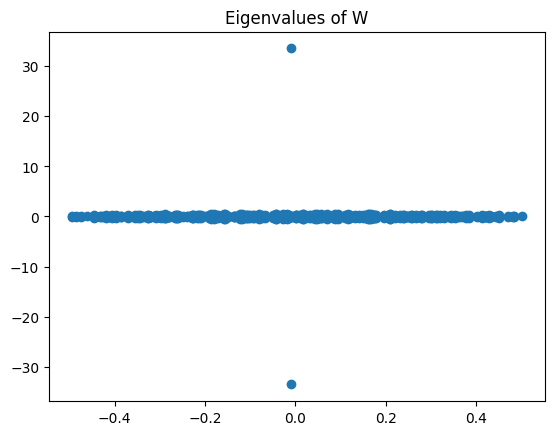

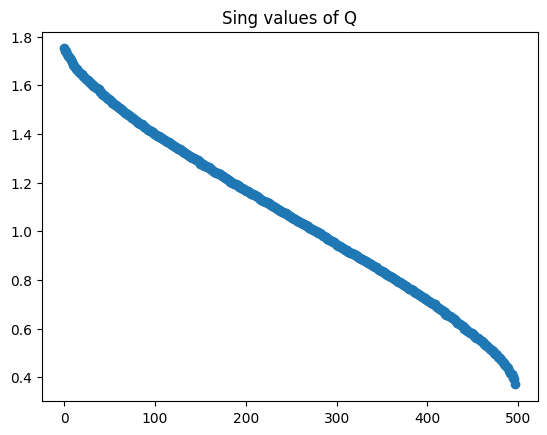

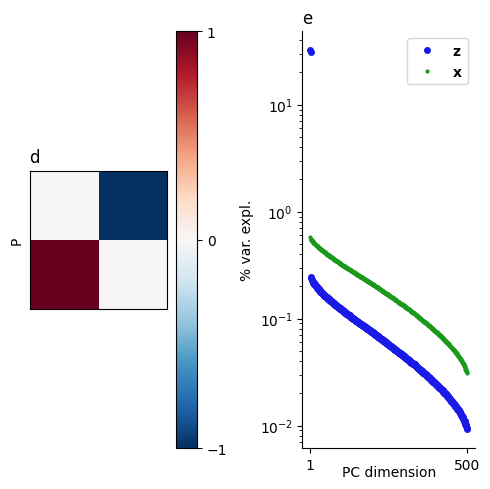

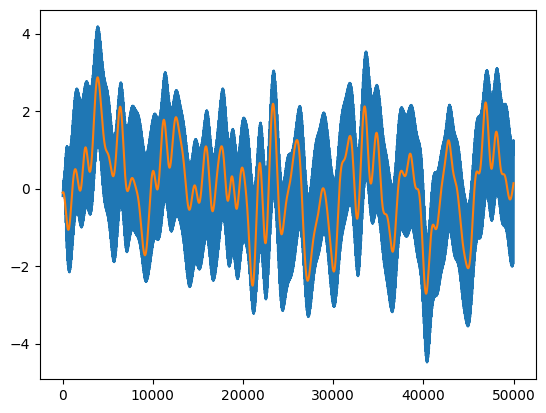

In [ ]:
# ROTATE NORMAL, SYMMETRIC EXAMPLE TO GET NORMAL NON-SYMMETRIC 
# ALSO NEED TO IMPOSE REPEATED SING VALUES

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm


import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA, GetOrthonormalVectors

# Save figures?
SaveFigs=True


device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)


####### Set parameter values

# Number of neurons in recurrent net
N = 500

# Parameters
rho=0.5

# Time step size, timescale of dynamics
dt = 0.01
tau=1

# Simulation time
T=10000

# Timescale and strength of Guassian random stimulus
taux=5
sigmax=1


###### Generate variables 

time=np.arange(0,T,dt)
Nt=len(time)

eta = dt/tau

# Random part of W
W1 = rho*torch.randn(N,N)/np.sqrt(N)


# Low rank part
sigmas = np.sqrt(N)*torch.tensor([1.5,1.5])
Sigma = torch.diag(sigmas)

# Generate 4 orthonormal vectors
OrthVecs = GetOrthonormalVectors(N,4)


### Sim 2: EP matrix
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = OrthVecs[0,:]
# V[:,1] = OrthVecs[1,:]

# Rotation matrix P
theta=torch.tensor(torch.pi/2)
R = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
              [torch.sin(theta),  torch.cos(theta)]])

# # Construct V
V = -U @ R.T


W0 = U@Sigma@V.T
W = W0+W1

P2 = U.T@V

L,M,RT=torch.linalg.svd(P2)
R=RT.T
print('M',M)


# ### Sim 2: EP matrix
# U = torch.zeros(N,2)
# U[:,0] = OrthVecs[0,:]
# U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = OrthVecs[1,:]
# V[:,1] = -OrthVecs[0,:]
# W0 = U@Sigma@V.T
# W = W0+W1
# P2 = U.T@V


# U = torch.zeros(N,2)
# U[:,0] = OrthVecs[0,:]
# U[:,1] = OrthVecs[1,:]
# V = torch.zeros(N,2)
# V[:,0] = -OrthVecs[0,:]
# V[:,1] = -OrthVecs[1,:]
# W0 = U@Sigma@V.T
# W = W0+W1


lamW2 = torch.linalg.eigvals(W.cpu())
print('max real lam2(W)',torch.real(lamW2).max().item())


plt.figure()
plt.plot(np.real(lamW2),np.imag(lamW2),'o')
plt.title('Eigenvalues of W')

Q=torch.eye(N)-W
UQ,SQ,VQT=torch.linalg.svd(Q)
VQ=VQT.T

plt.figure()
plt.plot(SQ[2:],'o')
plt.title('Sing values of Q')


# Generate Gaussian noise
with torch.no_grad():
    t0=tm()
    x = sigmax*MakeSmoothGaussianProcess(taux,Nt,dt,N,device=device).T
    x = x[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')

# Compute PCA of stimulus, x
with torch.no_grad():   
    Ux,Sx=TorchPCA(x[0,:,:], scaled=False)

model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)
with torch.no_grad():
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history
    tsim = tm()-t0
    #print('Time for  sim:',tsim,'s')
    Uz12,Sz2=TorchPCA(z[0,:,:], scaled=False)

#####  Make figure
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N

fig, axes = plt.subplot_mosaic("de",figsize=(5,3))

#axes['x'].axis('off')
#axes['x'].text(.25,.4,'something\nhere?',color=(.5,.5,.5))
# axes['x'].set_title('x',loc='left')

# ####### PANEL A ######
# c0='a'
# ax0 = axes[c0]
# ax0.axis('off')
# #plt.rcParams['text.usetex'] = True
# ax0.text(.5,.5,r'$W_0=USV^T$')
# ax0.text(.5,0,r'$P=U^TV$')
# ax0.set_title(c0,loc='left')


# ####### PANEL B ######
# c0='b'
# ax0 = axes[c0]
# #ax0.plot(np.arange(N)+1,100*Sz1/Sz1.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
# ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
# ax0.set_xscale('linear')
# ax0.set_yscale('log')
# #ax0.set_xlabel('PC dim.')
# ax0.set_xticks([1, 50, 100])
# #ax0.set_yticks([10, 100])
# ax0.set_ylabel('% var. expl.')
# ax0.legend()
# ax0.set_title(c0,loc='left')
# sns.despine(ax=ax0)

# Define functions for plotting P matrix and plotting PCA for z
def PPlot(P,c0):
    ax0 = axes[c0]
    im = ax0.imshow(P, cmap='RdBu_r', vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax0)
    cbar.set_ticks([-1,0,1])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_ylabel('P')
    ax0.set_title(c0,loc='left')

def SzPlot(Sz,c0):
    ax0 = axes[c0]
    ax0.plot(np.arange(N)+1,100*Sz/Sz.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
    ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
    ax0.set_xscale('linear')
    ax0.set_yscale('log')
    #ax0.set_xlabel('PC dim.')
    ax0.set_xticks([1, N])
    #ax0.set_yticks([10, 100])
    ax0.set_ylabel('% var. expl.')
    #ax0.legend()
    ax0.set_title(c0,loc='left')
    sns.despine(ax=ax0)


PPlot(P2,'d')
SzPlot(Sz2,'e')
axes['e'].legend()
axes['e'].set_xlabel('PC dimension',labelpad=-5)

fig.tight_layout()

plt.figure()
print(z.shape)
print(x.shape)
Q=torch.eye(N)-W
A=torch.linalg.inv(Q)
tplot = 50000
iplot=15
plt.plot(z[0,:tplot,iplot])
plt.plot((A@x[0,:tplot,:].T)[iplot,:])

In [ ]:
print(z.shape)
print(x.shape)
Q=torch.eye(N)-W
A=torch.linalg.inv(Q)
tplot = 50000
iplot=15
plt.plot(z[0,:tplot,iplot])
plt.plot((A@x[0,:tplot,:].T)[iplot,:])